In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Texata Finals 2015
Álvaro Barbero Jiménez

# Introduction

The challenges proposed for this round are the following:

* WordNet From Cisco Documents and Discussions
* Automated Summarization of Conversations
* Automated Clustering of Conversations
* Automated Discovery of Contents based on Conversations
* Document Similarity and Linkage

Most of them surround the idea of being able to define similarities between words or documents. Therefore, my proposal here is the develop a way to transform any word or text into an object over which a good measure of similarity can be defined.

## The key idea

I can use a semantic embedding method to map each word to a semantic vector space. In this space the similarity in meaning of a word is correlated to a vector distance, so then calculating groups of similar terms becomes easy and practical. The hard part is, of course, computing such semantic embedding.

Different methods for doing this embedding are already available, the most widespread being centered on the idea of the word2vec algorithm. Through the training of a neural network on huge amounts of unlabeled text, the network can produce a vector representation for each observed word of the language that integrates sintactic and semantic information. Training such a model can be extremely lengthy, but fortunately pretrained models on wikipedia texts are already available. One such model is polyglot, which we will use in its English version:

In [14]:
from texata import semantic
embeddings = semantic.loadembedding('models/polyglot-en.pkl')

We can check that these precomputed embeddings make sense by finding the nearest neighbors in the semantic vector space of some test words:

In [15]:
testwords = ["green", "Obama", "Spain", "data", "router"]
for word in testwords:
    neighbors = embeddings.nearest_neighbors(word)
    print word, "is close to", neighbors

green is close to [u'blue', u'white', u'red', u'yellow', u'black', u'grey', u'purple', u'pink', u'light', u'gray']
Obama is close to [u'Putin', u'Reagan', u'Stalin', u'LaRouche', u'Mugabe', u'Nixon', u'Palin', u'McCain', u'Ahmadinejad', u'Netanyahu']
Spain is close to [u'Italy', u'Portugal', u'Brazil', u'Argentina', u'Bulgaria', u'Switzerland', u'Hungary', u'Sweden', u'Cuba', u'Peru']
data is close to [u'information', u'application', u'software', u'content', u'energy', u'material', u'media', u'materials', u'audio', u'infrastructure']
router is close to [u'firewall', u'modem', u'motherboard', u'decoder', u'filesystem', u'smartphone', u'handset', u'workstation', u'transponder', u'adapter']


Seem to work! Semantically related word appear as the closest neighbors. We can test this more thoroughly by visualizing the embeddings, by performing a hierarchical clustering of each word and its nearest neighbors in the semantic space:

In [16]:
import numpy as np
neighbors = {word: embeddings.nearest_neighbors(word) for word in testwords}
vectors = np.array([embeddings[word] for key in neighbors for word in neighbors[key]], dtype='float')
cluster = [index for key in neighbors for index, word in enumerate(neighbors[key])]

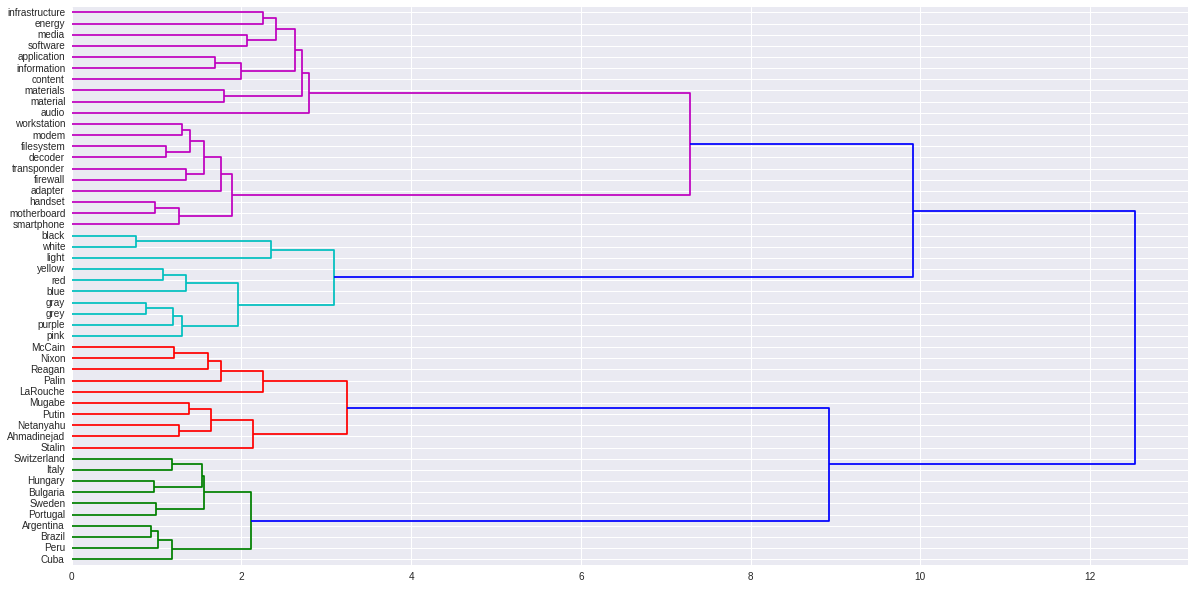

In [17]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(vectors, 'ward')
plt.figure(figsize=(20,10))
dendrogram(Z, orientation = 'left', labels = [word for key in neighbors for word in neighbors[key]])
plt.show()

It works very well indeed! Actually, the group of words related to "data" and "router" are closer in the semantic space than other groups of words.

Of course, a language model trained on the english Wikipedia will probably not be a correct representation of the Cisco Networking terminology and related technical terms, although it will be a very good model for other more common words. Therefore I propose to use a combined model, using both a general language model and a domain-specific language model.

In particular, I will use 3 language embeddings:
* A general english language model from Wikipedia
* A computed technical language model from relevant Stackexchange communities.
* A compute specific language model from CISCO data.

To do so I have prepared code to load all this data into a Elasticsearch database and the compute the embeddings in a memory-friendly way. Details on how this is done are in the *dataloader* and *embeddings* notebooks. All support code created for this project is under the *texata* Python module, together with some extra scripts in the *helperscripts* folder.

## Testing the embeddings

Now we will use all the semantic embeddings we have generated, to enrich our semantic representation:

In [18]:
modelsdir = 'models/'
modelfiles = ['polyglot-en.pkl', 'word2vec-cisco.pkl', 'word2vec-stackexchange.pkl']
embeddings = [semantic.loadembedding(modelsdir + modelfile) for modelfile in modelfiles]

Let's test the semantic embedding by loading data from posts in the forum. Ideally, all texts from the same post should be closer in the semantic space.

Let's load some of the data and compute their semantic vectors.

In [19]:
from texata import text
from texata import semantic
import itertools
corpus = text.PostsCorpus(['support-forums'])
groupsample = itertools.islice(corpus.textsbygroups(), 20)
posttexts = {i : texts for i,texts in enumerate(groupsample)}
postids = [i for i in posttexts for text in posttexts[i]]
vectors = [semantic.embeddingbyall(text, embeddings) for index in posttexts for text in posttexts[index]]

Not let's visualize the vector space through hierarchical clustering:

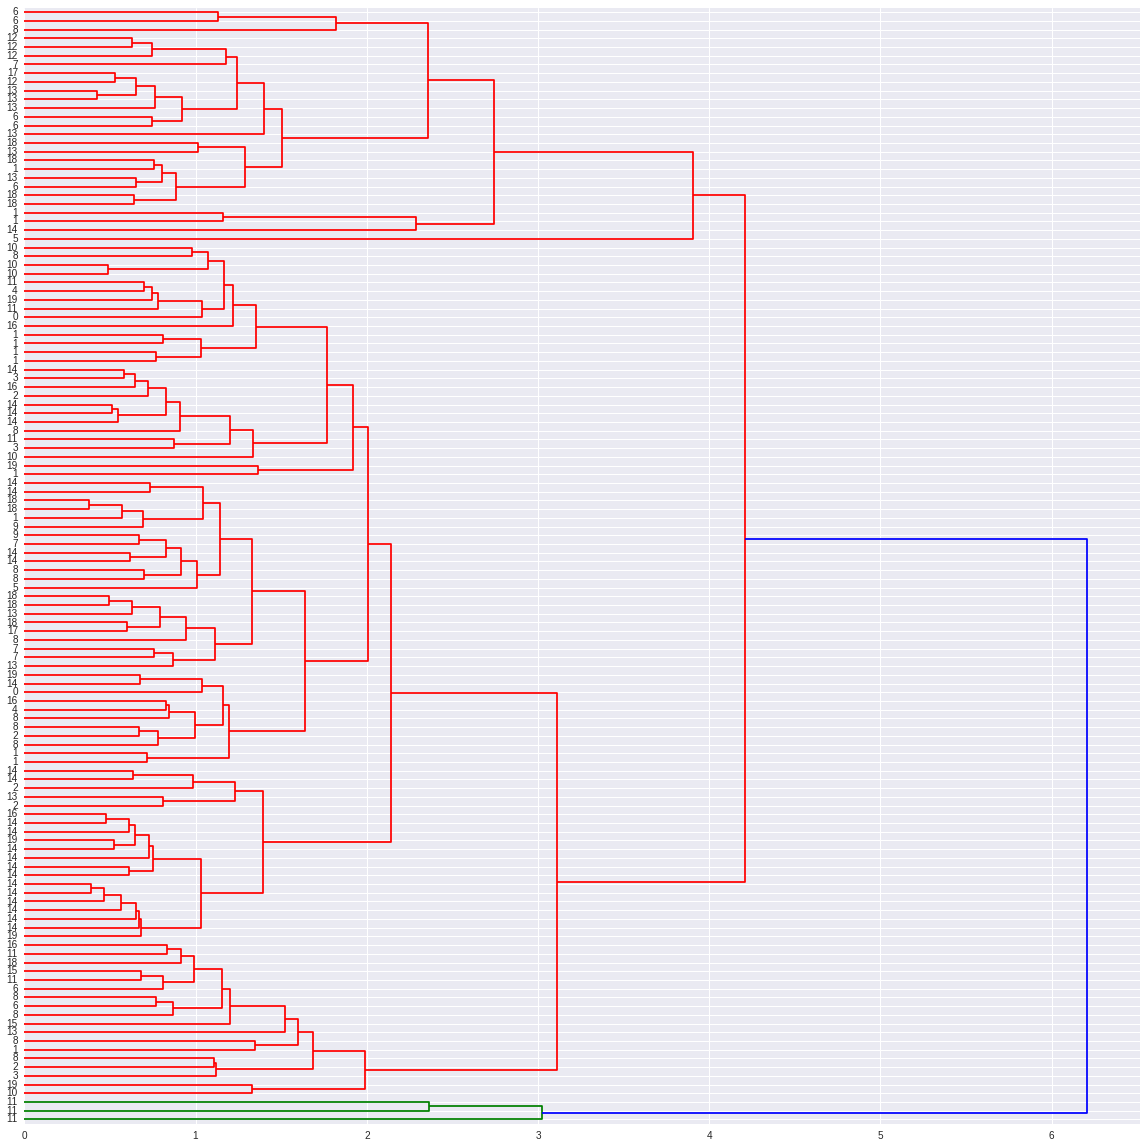

In [20]:
Z = linkage(vectors, 'ward')
plt.figure(figsize=(20,20))
dendrogram(Z, orientation = 'left', labels = postids)
plt.show()

Looks like texts referring to the same post are kind of close in the semantic space. But just by this plot it's hard to judge. We need a more precise way to measure the clustering quality. We can do that by computing the similarity between texts in the same group, as opposed to texts in different groups

In [21]:
from texata import clustering
vectorsbygroups = [[semantic.embeddingbyall(text, embeddings) for text in posttexts[index]] for index in posttexts]
clustering.intergroupscore(vectorsbygroups)

1.07113224035426

If we only used one embedding we would get:

In [22]:
vectorsbygroups = [[semantic.embeddingbyall(text, embeddings[0:1]) for text in posttexts[index]] for index in posttexts]
clustering.intergroupscore(vectorsbygroups)

0.69191893918103398

So the idea of using several embeddings certainly helps!

## Cluster similarity in Stackoverflow

To measure cluster quality we would ideally need some desired cluster labels on the CISCO data. Since we don't have that, we will try our approach on a similar problem, considering Stackoverflow labels as different clusters.

Let's try it on a particular Stackexchange community:

In [23]:
from texata import text
corpus = text.PostsCorpus(["robotics.stackexchange.com"])

Let's compute the embeddings of all texts that have labels in this corpus:

In [24]:
from texata import semantic
modelsdir = 'models/'
modelfiles = ['polyglot-en.pkl', 'word2vec-cisco.pkl', 'word2vec-stackexchange.pkl']
embeddings = [semantic.loadembedding(modelsdir + modelfile) for modelfile in modelfiles]
mapper = semantic.SemanticMapper(embeddings, semantic.embeddingbyall)
vectors, tags = zip(*[(mapper.map(item[0]),item[1]) for item in corpus.itertagged()])

Now we compute this quality metric which encourages high similarities for posts with common tags, and penalizes similarities in posts with completely different sets of tags:

In [25]:
score = clustering.intertagscore(vectors, tags)
print score

0.7300018904


How is this better from using a general model language? Let's test:

In [26]:
simplemapper = semantic.SemanticMapper(embeddings[0:1], semantic.embeddingbyall)
simplevectors = [simplemapper.map(item[0]) for item in corpus.itertagged()]
score = clustering.intertagscore(simplevectors, tags)
print score

0.519374504602


It indeed seems that using a more specific embedding has certainly improved the clustering score. So the domain-specific embeddings are being able to capture some semantic info related to the actual labels the users are choosing!

## Applications

### Main application: recovering similar posts

One direct application of the semantic space build above is to automatically recover posts that are very similar in content to a newly proposed post. This could help to automatically detect duplicate questions, which in turn can lead to a faster customer service: is the customer is suggested another forum thread or document that answers his problem, even before he submits his new question, he will not need to wait for another forum user or technician to read and reply his question.

Implementing such a search might be expensive if we have to compute (or even recover) the semantic vectors for every text in our corpus. To solve this use what I will do is first perform a quick search using Elasticsearch, take the top 100 elements from that search and then apply semantic similarity to those. This way I can avoid expending time comparing the semantic vectors of text that are highly unrelated.

So for instance, if we take the fictional text:

In [27]:
from texata import text
question = ("Hi there:"
              "I've been getting some weird PS messages in the log during the last hours."
              "They look like this: "
              "%ENVM-6-PSLEV: Power Supply 1 state changed from shutdown to normal Nov 6 11:37:00."
              "Any idea what could be going on?")

To compute similarities we will prepare a SemanticMapper object that performs all the steps to take a text to the semantic space:

In [28]:
from texata import semantic
modelsdir = 'models/'
modelfiles = ['polyglot-en.pkl', 'word2vec-cisco.pkl', 'word2vec-stackexchange.pkl']
embeddings = [semantic.loadembedding(modelsdir + modelfile) for modelfile in modelfiles]
mapper = semantic.SemanticMapper(embeddings, semantic.embeddingbyall)

The most similar texts in the corpus are:

In [29]:
from texata import clustering
corpus = text.PostsCorpus(["cdets", "support-forums", "techzone"])
clustering.nearestneighbors(question, corpus, mapper)

[(u"Hi All ! I started experiencing a weird problem with one of my 3750s today . It seems that connectivity to the managment IP has become sporadic ... I can ping it and get maybe 2-3 responses , then a couple minutes of no responses . However , the switch is still passing traffic normally , users connected to it are not experiencing any symptoms . Switch is running IOS 12.2 ( 44 ) SE2 and is connected via 802.1q trunk to 2801 with only 2 VLANs . There 's really not a lot of traffic going through this switch . I ca n't connect to the switch from the directly connected router or elsewhere on my network . I sat with my finger on the `` Get Tree '' button in my SNMP MIB Browser , to try gathering some data when it became available to begin narrowing down where the issue could be . Here 's what I 've found / checked so far : CPU ( via CISCO-PROCESS-MIB ) : around 5-10 % for all 3 values ( 1 sec , 5 sec etc ) Memory : There is pleanty of memory free , nothing out of the ordinary Syslog : Lo

There indeed seem to appear some references to a similar problem.

Let's check another example:

In [30]:
question = "HI, all of our enterprise switches are sert to send syslog messages from facility local3. this is partly because our linux syslog server loggs its boot syslog  messages from  facility local7 an we could't use the default  facility of local7 on our cisco switches. LMS4.2s syslog daemon is set to recieve syslog messages from facility local7. how can i change it so that it can listen for facility local3 and also make sure the syloganalyzer and automated action  work fine. thanks, Kerim "

In [31]:
clustering.nearestneighbors(question, corpus, mapper)

[(u"HI , all of our enterprise switches are sert to send syslog messages from facility local3 . this is partly because our linux syslog server loggs its boot syslog messages from facility local7 an we could't use the default facility of local7 on our cisco switches . LMS4.2s syslog daemon is set to recieve syslog messages from facility local7 . how can i change it so that it can listen for facility local3 and also make sure the syloganalyzer and automated action work fine . thanks , Kerim I have this problem too .",
  0.99494740418693284),
 (u'I have customer who wants to receive all syslog from all routers and switches but is not willing to accept it in a syslog server . He wants it in raw text format prior to any syslog server . Clear a solution is to ssh into every device periodically and capture the output of the syslog buffe to a text file but that would be labor intensive/prohibitive and not guarantee to catch all syslog if the device is really spitting out lost messages ( this s

## Bonus track: creating a WordNet of Cisco terms

To see whether this is feasible with the mapping I created, let's plot a projection of the semantic space for the Cisco corpus:

In [32]:
# Load embeddings
from texata import semantic
ciscoembedding = semantic.loadembedding('models/word2vec-cisco.pkl')

Plotting all the words in this model is useless, as a lot of noise is bound to appear. Instead, I will plot only those words that do not appear in the english Wikipedia model, so that we are just taking specific Cisco language:

In [33]:
wikipediaembedding = semantic.loadembedding('models/polyglot-en.pkl')
ciscowords = set(ciscoembedding.words)
wikipediawords = set(wikipediaembedding.words)
selectedwords = {word for word in ciscowords if word not in wikipediawords}

We can't plot all the words, so let's select some subset:

In [34]:
import itertools
reducedwords = list(itertools.islice(selectedwords, 1000))
reducedvectors = np.array([ciscoembedding[word] for word in reducedwords])

Since the embedding is highly dimensional, we need to project it to 2D. For that we will use the t-SNE method:

In [35]:
import numpy as np
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
projection = model.fit_transform(reducedvectors.astype(dtype='float'))

Now let's plot a scatter plot of this:

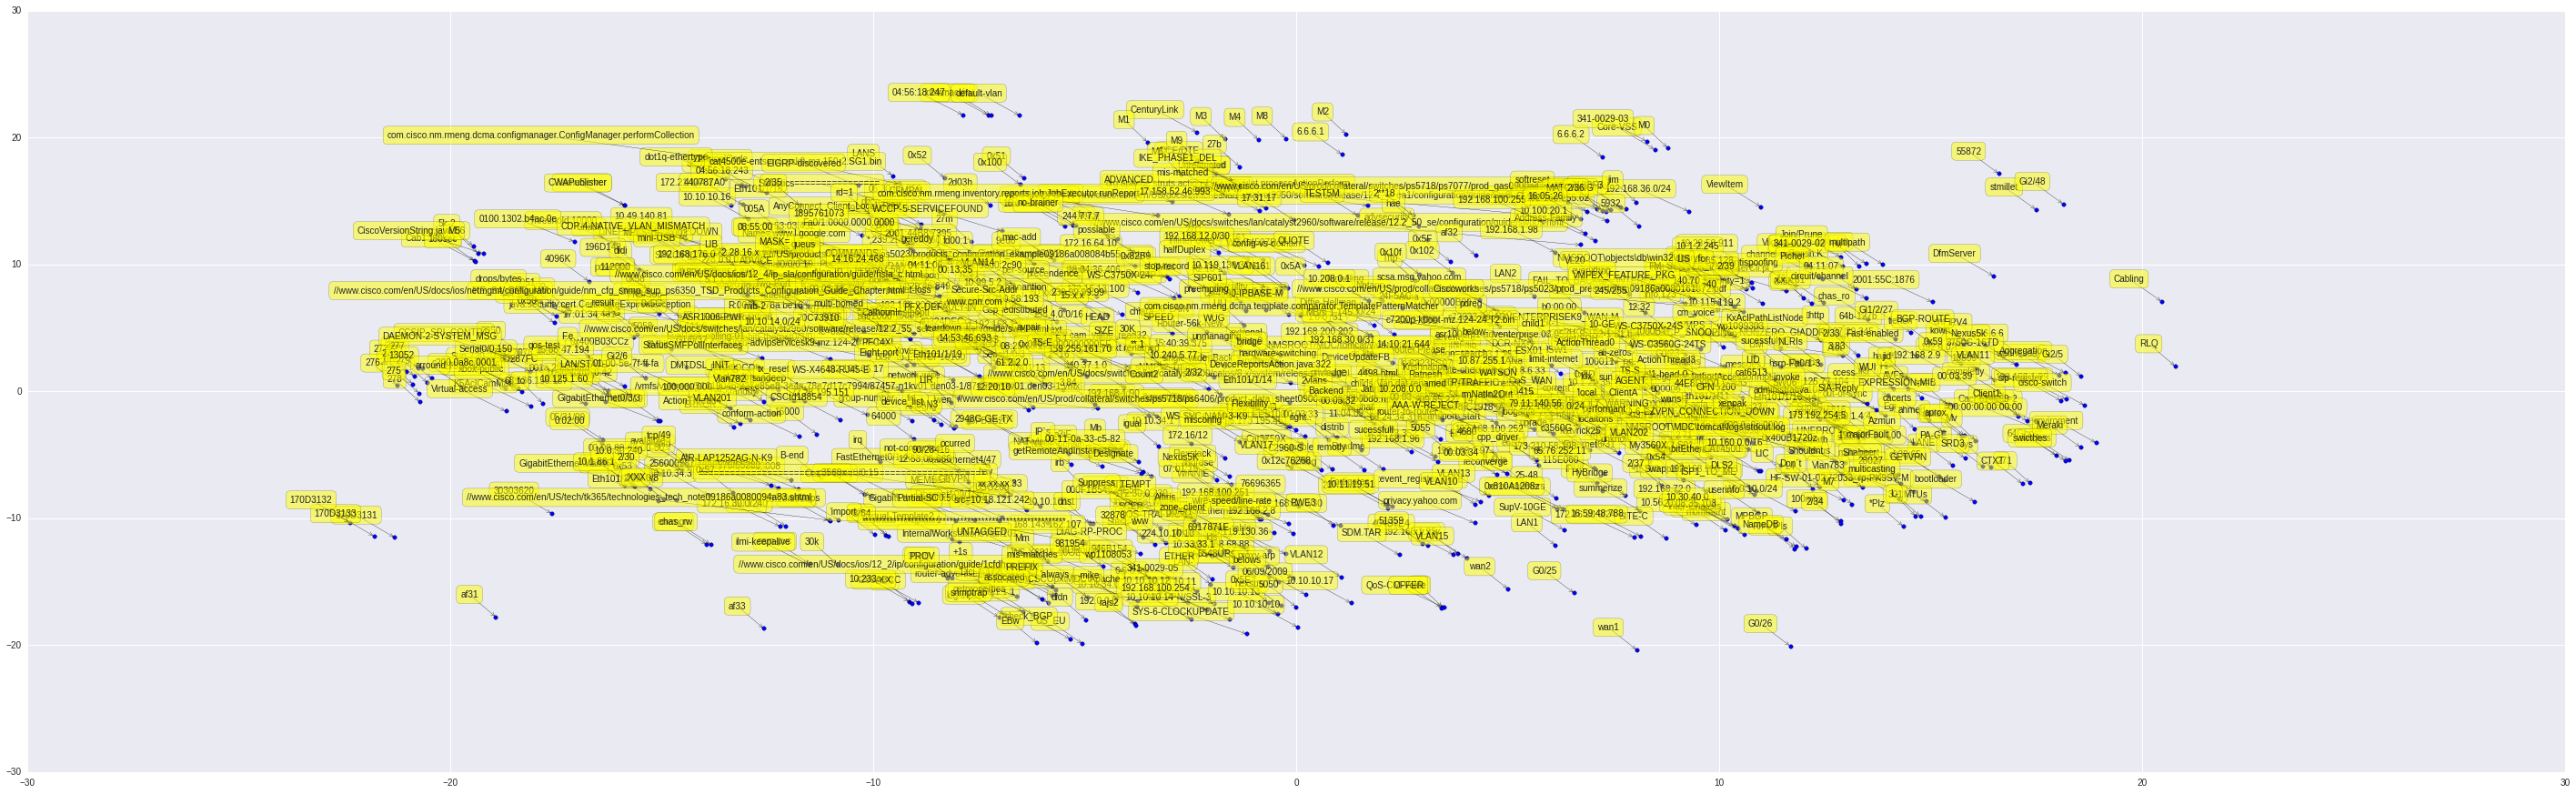

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,15))
plt.scatter(projection[:, 0], projection[:, 1], marker = 'o')
for word, x, y in zip(reducedwords, projection[:,0], projection[:,1]):
    plt.annotate(word, xy=(x,y), xytext = (-20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
)

We can't really see much of use here, but that might be because of the 2D embedding we have performed. Let's try again with a dendogram representation:

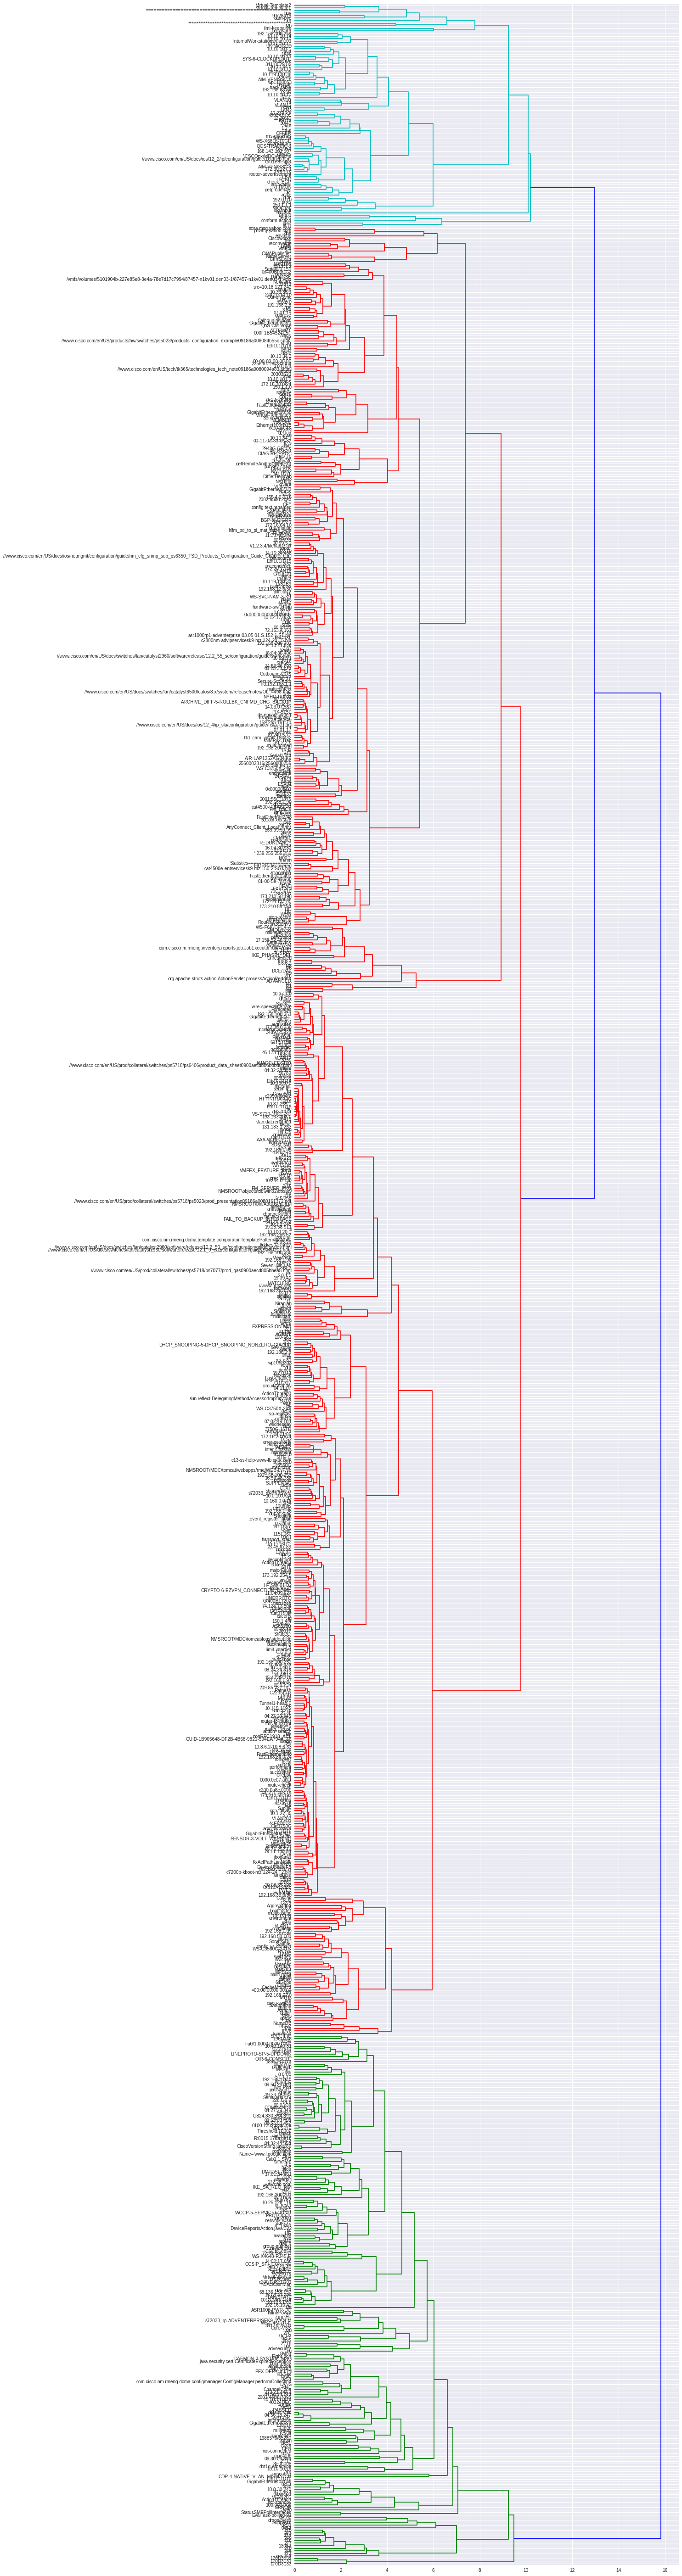

In [37]:
Z = linkage(reducedvectors, 'ward')
plt.figure(figsize=(15,100))
dendrogram(Z, orientation = 'left', labels = reducedwords)
plt.show()

It seems the corpus would need a little bit of further cleaning, but nevertheless we can already see how concepts like IPs, MACs or LAN names tend to appear together.

## Closing

This report has been just but a prospective attempt to use semantic embeddings for the problem of faster question answering in Cisco Support Community. In order to implement this solution at full scale the following points should be considered:
* Further cleaning of the corpus data is needed.
* Scalability is not an issue due to Elasticsearch's horizontal scaling capabilities.
* The semantic models for CISCO data should be recomputed frequently to adapt to new vocabulary or product names.
* More advanced semantic models are possible, such as the use of Paragraph Vector models that try to capture the the semantics of a whole sentence or paragraph.

Therefore, there is significant room for improvement. Nevertheless this study has shown that semantic embeddings might be a viable way of implementing a related-question detection system, and so shows that this could be a fruitful line of research.